# Mammography data Analysis

The goal of the project is to find the Cancer type, position and radious of the cyst from mammography

### Init

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import cv2
import os

### Functions

In [110]:
def load_data(file_path):
    df = pd.read_csv(file_path, sep=' ', header=None)
    df.columns = ['ImageID', 'BreastDensity', 'AbnormalityType', 'Assessment', 'X', 'Y', 'Radius']
    return df

def initial_analysis(df):
    print(df.head(5)) # Display the first 5 rows of the DataFrame
    print(df.info()) # Display information about the DataFrame
    print("\nTotal NaN values in DataFrame:", df.isna().sum().sum())  # Count all NaNs


def convert_coordinates_to_float(df):
    # Convert specified columns to float, handling errors
    df_copy = df.copy()
    for col in ['X', 'Y', 'Radius']:
        if col in df_copy.columns:
            df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce').astype(float)
    return df_copy

def fill_nan(df):
    df_copy = df.copy()

    # Fill numeric coordinate/size columns with 0
    for col in ['X', 'Y', 'Radius']:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].fillna(0)

    # Fill Assessment with 'N' for Normal
    if 'Assessment' in df_copy.columns:
        df_copy['Assessment'] = df_copy['Assessment'].fillna('N')

    return df_copy


In [111]:
def initial_plot(df, figsize=(5, 4), dropna=False, max_cols_per_row=4):
    # Columns to include
    include_cols = ['Assessment', 'BreastDensity', 'AbnormalityType']

    # Filter to keep only columns present in the DataFrame
    categorical_cols = [col for col in include_cols if col in df.columns]

    if not categorical_cols:
        print("No specified columns found in the DataFrame.")
        return

    # Grid dimensions
    total_plots = len(categorical_cols)
    n_rows = math.ceil(total_plots / max_cols_per_row)
    n_cols = min(total_plots, max_cols_per_row)

    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0] * n_cols, figsize[1] * n_rows))
    axes = axes.flatten() if total_plots > 1 else [axes]

    # Plot each categorical column
    for i, col in enumerate(categorical_cols):
        counts = df[col].value_counts(dropna=dropna)
        axes[i].bar(counts.index.astype(str), counts.values)
        axes[i].set_title(col)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [112]:
def enforce_numeric_coords(df):
    for col in ["X", "Y", "Radius"]:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    return df

In [113]:

def plot_breastdensity_vs_abnormalitytype(df):
    """Plot Breast Density vs Abnormality Type heatmap."""
    plt.figure(figsize=(8,5))
    ct_density_abn = pd.crosstab(df["BreastDensity"], df["AbnormalityType"])
    sns.heatmap(ct_density_abn, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Breast Density vs Abnormality Type")
    plt.ylabel("Breast Density")
    plt.xlabel("Abnormality Type")
    plt.show()


In [114]:
def plot_abnormalitytype_vs_assessment(df):
    """Plot Abnormality Type vs Assessment stacked bar."""
    plt.figure(figsize=(8,5))
    ct_abn_assess = pd.crosstab(df["AbnormalityType"], df["Assessment"])
    ct_abn_assess.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(8,5))
    plt.title("Abnormality Type vs Assessment")
    plt.ylabel("Count")
    plt.xlabel("Abnormality Type")
    plt.xticks(rotation=45)
    plt.show()


In [115]:
def plot_breastdensity_vs_assessment(df):
    """Plot Breast Density vs Assessment grouped bar."""
    plt.figure(figsize=(6,4))
    sns.countplot(data=df.dropna(subset=["Assessment"]), 
                  x="BreastDensity", hue="Assessment", palette="Set2")
    plt.title("Breast Density vs Assessment")
    plt.ylabel("Count")
    plt.xlabel("Breast Density")
    plt.show()


In [116]:

def plot_mias_image(df, image_folder, image_id):
    """
    Plots one MIAS dataset image with abnormality marked.
    
    df            : DataFrame containing parsed MIAS data
    image_folder  : Path to folder containing PGM images
    image_id      : ImageID from the DataFrame (e.g., 'mdb001')
    """
    
    # Get the row for this image
    row = df[df["ImageID"] == image_id].iloc[0]
    
    # Build image file path
    img_path = os.path.join(image_folder, f"{image_id}.pgm")
    
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Plot image
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap="gray")
    plt.title(f"{image_id} | {row['BreastDensity']} | {row['AbnormalityType']} | {row['Assessment']}")
    
    # Draw circle only if Radius > 0
    if row["Radius"] > 0:
        circle = plt.Circle((row["X"], img.shape[0] - row["Y"]),  # Flip Y for image coordinates
                            row["Radius"], 
                            color='red', fill=False, linewidth=2)
        plt.gca().add_patch(circle)
    
    plt.axis("off")
    plt.show()


### load data

In [117]:
df = load_data('C:/Users/Sreerag/Documents/ML_chellange/Detection-of-Breast-Abnormalities/Detection-of-Breast-Abnormalities-from-Mammogram/Data/Raw_data/Parse_file/Parse_data.txt')

### Initial Analysis

Analysing for nan and empty values

In [118]:
initial_analysis(df) # Initial analysis of the DataFrame

  ImageID BreastDensity AbnormalityType Assessment    X    Y  Radius
0  mdb001             G            CIRC          B  535  425   197.0
1  mdb002             G            CIRC          B  522  280    69.0
2  mdb003             D            NORM        NaN  NaN  NaN     NaN
3  mdb004             D            NORM        NaN  NaN  NaN     NaN
4  mdb005             F            CIRC          B  477  133    30.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ImageID          330 non-null    object 
 1   BreastDensity    330 non-null    object 
 2   AbnormalityType  330 non-null    object 
 3   Assessment       123 non-null    object 
 4   X                122 non-null    object 
 5   Y                122 non-null    object 
 6   Radius           119 non-null    float64
dtypes: float64(1), object(6)
memory usage: 18.2+ KB
None

Total NaN

Data Descriptions

- **X**  
  The horizontal coordinate (in pixels) of the abnormality's center within the mammogram image.

- **Y**  
  The vertical coordinate (in pixels) of the abnormality's center within the mammogram image.

- **Radius**  
  The approximate radius (in pixels) of the abnormality region, measured from the center `(X, Y)` to the boundary.  
  This is useful for defining a region of interest (ROI) for further analysis, such as cropping or segmentation.


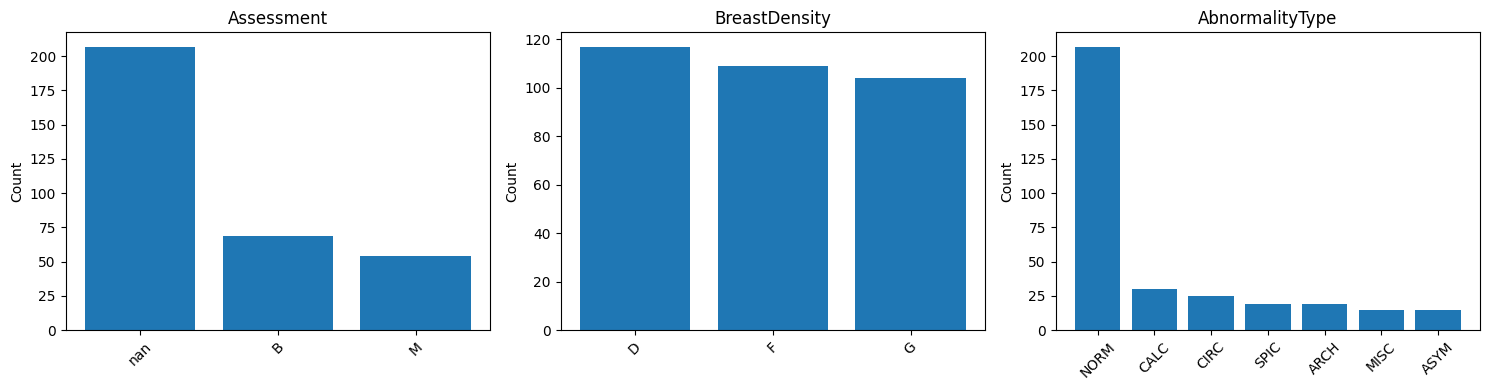

In [119]:
initial_plot(df)

### Preprocessing

Filling nan and empty data with suitable values

In [120]:
df = fill_nan(df)

Recheck_nan

In [121]:
initial_analysis(df)  # Re-check after filling NaN values

  ImageID BreastDensity AbnormalityType Assessment    X    Y  Radius
0  mdb001             G            CIRC          B  535  425   197.0
1  mdb002             G            CIRC          B  522  280    69.0
2  mdb003             D            NORM          N    0    0     0.0
3  mdb004             D            NORM          N    0    0     0.0
4  mdb005             F            CIRC          B  477  133    30.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ImageID          330 non-null    object 
 1   BreastDensity    330 non-null    object 
 2   AbnormalityType  330 non-null    object 
 3   Assessment       330 non-null    object 
 4   X                330 non-null    object 
 5   Y                330 non-null    object 
 6   Radius           330 non-null    float64
dtypes: float64(1), object(6)
memory usage: 18.2+ KB
None

Total NaN

In [122]:
enforce_numeric_coords(df)  # Ensure numeric coordinates
df.info()  # Display DataFrame info after enforcing numeric coordinates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ImageID          330 non-null    object 
 1   BreastDensity    330 non-null    object 
 2   AbnormalityType  330 non-null    object 
 3   Assessment       330 non-null    object 
 4   X                327 non-null    float64
 5   Y                327 non-null    float64
 6   Radius           330 non-null    float64
dtypes: float64(3), object(4)
memory usage: 18.2+ KB


Initial analysis of data after preprocessing

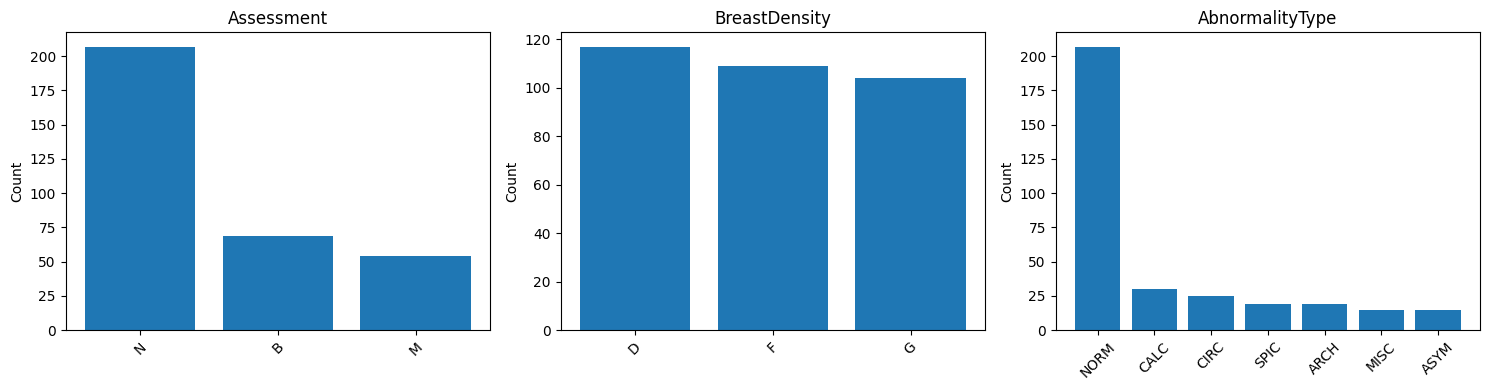

In [123]:
initial_plot(df)

### Save data

In [124]:
path = "C:/Users/Sreerag/Documents/ML_chellange/Detection-of-Breast-Abnormalities/Detection-of-Breast-Abnormalities-from-Mammogram/Data/Preprocessed_data/Parse_file/Parse_data_preprocessed"
df.to_csv(path, index=False)

### Exploratory Data Analysis (EDA)

Targets
1) Cancer type
2) X, Y, Radious

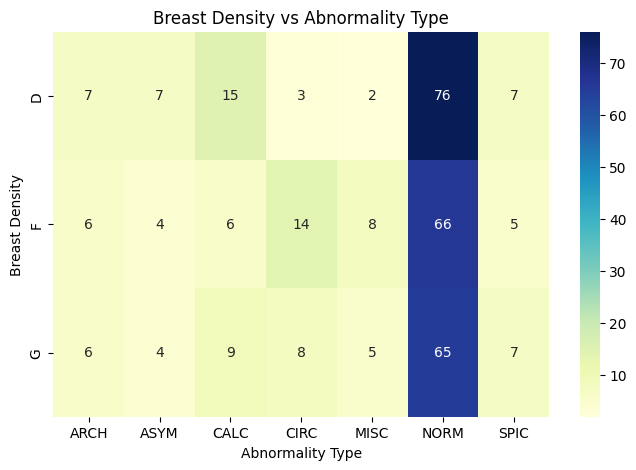

In [125]:
plot_breastdensity_vs_abnormalitytype(df)


D – Dense-glandular, 
F – Fatty ,
G – Fatty-glandular ,

images of Dense-grandular and Fatty type have more upnormalities in this dataset.


<Figure size 800x500 with 0 Axes>

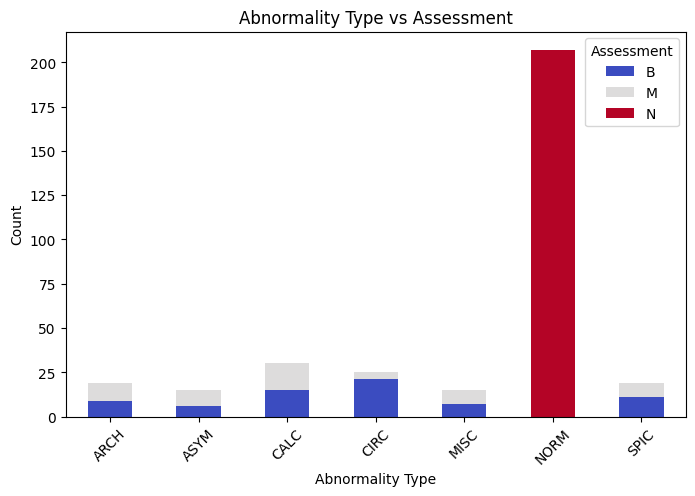

In [126]:
plot_abnormalitytype_vs_assessment(df)

MIAS Abnormality Categories

- **CALC** – Calcification (tiny calcium deposits, may be benign or malignant)  
- **CIRC** – Well-defined/circumscribed mass (round/oval with clear edges)  
- **SPIC** – Spiculated mass (irregular shape with radiating lines, often malignant)  
- **MISC** – Other ill-defined mass (not clearly round/oval, fuzzy borders)  
- **ARCH** – Architectural distortion (normal breast structure is disrupted)  
- **ASYM** – Asymmetry (one breast shows more tissue density than the other)  
- **NORM** – Normal (no abnormality detected)  

The chance of tumor being manignen is less for CIRC condeation compaired to all other upnormalities

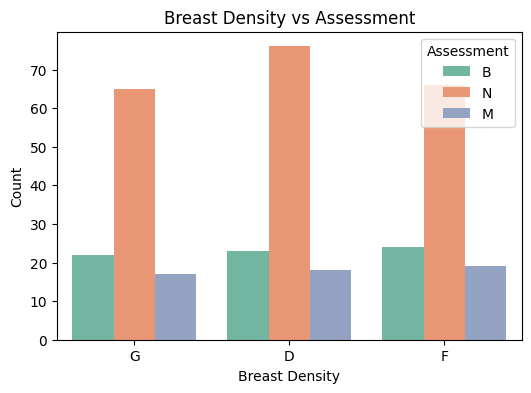

In [127]:
plot_breastdensity_vs_assessment(df)

The dataset have similar quantity of images with tumors for each brest density category. 

### Image analysis

Plot image 

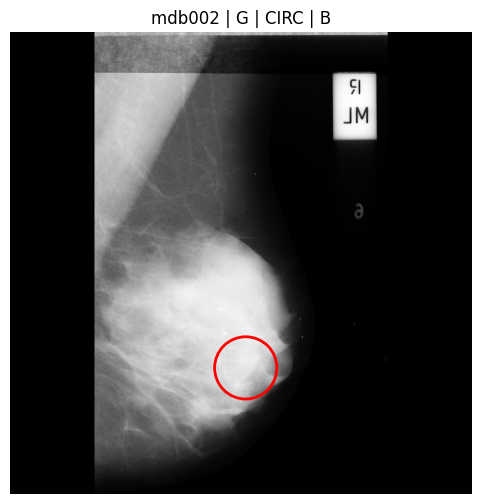

In [128]:
Image_folder = "C:/Users/Sreerag/Documents/ML_chellange/Detection-of-Breast-Abnormalities/Detection-of-Breast-Abnormalities-from-Mammogram/Data/Raw_data/Images"
plot_mias_image(df, Image_folder, 'mdb002')  # Example image ID